# Lab 3: EM and VAE

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 24, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts before you send them!

$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included.

In [2]:
%pylab inline
import cPickle, gzip

# load data
with gzip.open('mnist_small.gz', 'r') as f:
    mnist_images, mnist_labels = cPickle.load(f)

mnist_dim = (28, 28)
print "MNIST data loaded;", \
    " number of samples:", len(mnist_labels), \
    '; number of pixels per sample:', mnist_dim[0], 'x', mnist_dim[1]

Populating the interactive namespace from numpy and matplotlib
MNIST data loaded;  number of samples: 5000 ; number of pixels per sample: 28 x 28


## Part 1: Expectation Maximization
We use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5)
As we like to apply our Bernoulli mixture model, convert the MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding the dataset at an appropriate level. Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

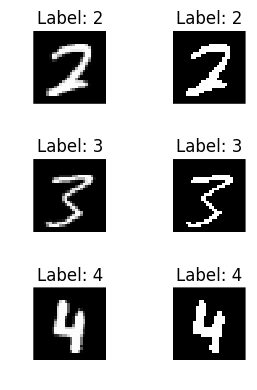

In [3]:
f, axarr = plt.subplots(3, 2, figsize=(3, 4))
j = 0
for i in range(len(mnist_labels)):
    if mnist_labels[i] == j + 2:
        axarr[j][0].axis('off')
        axarr[j][0].imshow(mnist_images[i].reshape((28, 28)), interpolation='none', cmap='gray')
        axarr[j][0].set_title('Label: {}'.format(mnist_labels[i]))
        
        axarr[j][1].axis('off')
        axarr[j][1].imshow(np.round(mnist_images[i].reshape((28, 28))), interpolation='none', cmap='gray')
        axarr[j][1].set_title('Label: {}'.format(mnist_labels[i]))
        
        if j == 2:
            break
        j += 1
        
plt.tight_layout()

### 1.2 Implementation (40)
Write a function ```EM(batch, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters your function should have are:
* ```batch``` :: input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize equations in ```numpy``` as  much as possible and clearly comment in your code where the E-step and where the M-step are performed.

In [4]:
def E_step(pi, mu, batch):
    mu_ = np.expand_dims(mu, axis=0)
    batch_ = np.expand_dims(batch, axis=1)

    G = np.power(mu_, batch_) * np.power(1 - mu_, 1 - batch_)
    G = np.prod(G, axis=2) * pi
    
    return G / np.expand_dims(np.sum(G, axis=1), axis=1)
    
def M_step(G, mu, batch):
    N_k = np.sum(G, axis=0)
    mu = np.dot(G.T, batch) /  np.expand_dims(N_k, axis=1)
    pi = N_k / np.sum(N_k)
    return pi, mu

def EM(batch, K=3, max_iter=1, toll=1e-6, pi=None, mu=None):
    
    # pi initialization if not given
    if pi is None:
        pi = np.random.uniform(0.5 / K, 1.5 / K, K)
        pi /= np.sum(pi, axis=0)
    
    # mu initialization if not given
    if mu is None:
        mu = np.abs(np.random.uniform(0.25, 0.75, (K, batch.shape[1])))
        mu /= np.sum(mu, axis=0)
    
    for i in range(max_iter):
        # E step
        G = E_step(pi, mu, batch)
        # M step
        pi_, mu_ = M_step(G, mu, batch)
        
        # check for convergence
        if (np.abs(pi - pi_) < toll).all() and (np.abs(mu - mu_) < toll).all():
            break
        else:
            pi, mu = pi_, mu_
            
    print 'iterations:', i + 1
    return pi, mu, G

In [5]:
def print_numbers(mu, K):
    plt.figure(figsize=(1 * K, 1))
    for i in range(K):
        plt.subplot(1, K, i+1)
        plt.imshow(mu[i].reshape((28, 28)), interpolation='none', cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

iterations: 31


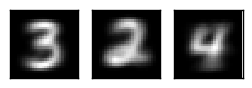

pi= [ 0.31558076  0.30777452  0.37664472]


In [5]:
K = 3
batch = mnist_images[(mnist_labels > 1) * (mnist_labels < 5)]
pi, mu, _ = EM(batch, K=K, max_iter=100)
print_numbers(mu, K)
print 'pi=', pi

### 1.2 Three digits test (10)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits. What are the identified mixing coefficients, and how do these compare to the true ones?

iterations: 61


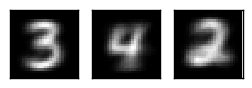

pi= [ 0.30007349  0.3594879   0.34043861]
true pi= [ 0.34853643  0.31245744  0.33900613]


In [6]:
K = 3
batch = np.round(mnist_images[(mnist_labels > 1) * (mnist_labels < 5)])
pi, mu, _ = EM(batch, K=K, max_iter=100)
print_numbers(mu, K)
print 'pi=', pi

a = np.array([np.sum(mnist_labels == i + 2) for i in range(3)], dtype=np.float32)
a /= np.sum(a)
print 'true pi=', a

It can be seen that the mixing coefficients resulting from the algorithm execution tend to have values that are close to the true value of the digits, in this case around 0.33.

### 1.3 More experiments (20)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation.

* __1.3.1__
    Use with more or less classes for $K$.
* __1.3.2__ 
    Use the image labels in ```mnist_labels``` to identify some misclassified images and see if you understand why.
* __1.3.3__ 
    Initialize the three classes with the true values of the parameters and see what happens.

#### 1.3.1 
Use with more or less classes for $K$.

iterations: 53


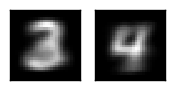

pi= [ 0.59324873  0.40675127]


In [7]:
K = 2
batch = mnist_images[(mnist_labels > 1) * (mnist_labels < 5)]
pi, mu, _ = EM(batch, K=K, max_iter=100)
print_numbers(mu, K)
print 'pi=', pi

In this case the value of K is less than the actual number of classes, so the algorithm needs to accorpate portions of one class into the others, creating less detailed reconstructions along with omitting one of the digits.

iterations: 100


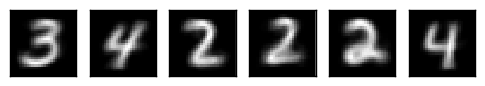

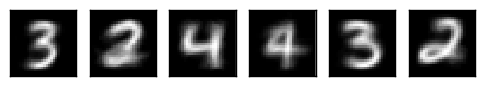

pi= [ 0.08833549  0.12435541  0.05780872  0.06816392  0.0857062   0.09461948
  0.09599456  0.05721384  0.0505592   0.10004231  0.09619308  0.0810078 ]


In [8]:
K = 12
batch = mnist_images[(mnist_labels > 1) * (mnist_labels < 5)]
pi, mu, _ = EM(batch, K=K, max_iter=100)
print_numbers(mu[0:6], 6)
print_numbers(mu[6:12], 6)
print 'pi=', pi

When K is set to be higher than the number of classes that have to be recognized the resulting reconstructions tend to be more specialized in particular appearances of the same digit, like shearing and different writing styles.

#### 1.3.2
Use the image labels in ```mnist_labels``` to identify some misclassified images and see if you understand why.

iterations: 31


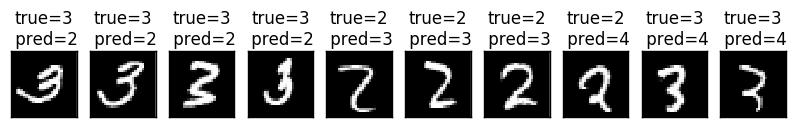

In [9]:
K = 3
batch = mnist_images[(mnist_labels > 1) * (mnist_labels < 5)]
batch_l = mnist_labels[(mnist_labels > 1) * (mnist_labels < 5)]

pi, mu, G = EM(batch, K=K, max_iter=100)
tr = [np.argmax(np.sum(G[batch_l == i + 2], axis=0)) for i in range(3)]
h = np.argmax(G[:,tr], axis=1) + 2 == batch_l

ms = batch[~h]

plt.figure(figsize=(10, 1))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(ms[i].reshape((28, 28)), interpolation='none', cmap='gray')
    plt.title('true=' + str(batch_l[~h][i]) + '\n pred=' + str((np.argmax(G[:,tr], axis=1) + 2)[~h][i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

When analyzing the misclassified digits we can see that the main problem is dealing with examples that prove to be slightly hard even for humans to classify (fourth and last one especially).

#### 1.3.3
Initialize the three classes with the true values of the parameters and see what happens.

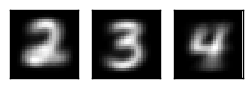

pi= [ 0.34853642  0.31245745  0.33900613]


In [6]:
K = 3
batch = mnist_images[(mnist_labels > 1) * (mnist_labels < 5)]
batch_l = mnist_labels[(mnist_labels > 1) * (mnist_labels < 5)]

pi = np.empty(3)
mu = np.empty((3, 784))

for i in range(3):
    pi[i] = np.sum(batch_l == i + 2)
    mu[i] = np.mean(batch[batch_l == i + 2], axis=0)

pi /= np.sum(pi)

pi, mu, _ = EM(batch, K=K, max_iter=100, pi=pi, mu=mu)

print_numbers(mu, K)
print 'pi=', pi

As we see the number of iterations drops compared to a random initialization of $\mu$ and $\pi$ (it converges w.t.r of a tollerance during the update in approximately half of the iterations). This is because initializing the $\pi$ values with the actual proportion of digits is already a good starting point, and the main optimization is done to the $\mu$ values.

### 1.4 Relation to Variational Inference (5)
Propose how you would alter the Bernoulli mixture model for use with a variational method (Bishop Ch.$10$). 

Which priors would you use and why? 

In a varational framework, parameters are considered as variable themselves. Thus, they are modeled as random variables with their own probability distributions.

Moreover, as usually in the Baeysian framework, we would like to give a prior over variables.

We would use the following priors:
* $Beta(\mu|a, b)$ for $\mu$ since $\mu$ is modelled as a Bernoulli distribution and the Beta distribution is a coniugate prior of it.
* $Dir(\pi|\alpha)$ for $\pi$ since $\pi$ is modelled as a Categorial distribution and the Dirichlet distribution is a coniugate prior of it.

Using coniugate priors is useful and mathematically convenient since then the posterior has the same distribution family of the prior.

Then, in order to perform variational inference, we have to derive the new update steps.

## Part 2: Variational Auto-Encoder
A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part, that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

More information can be found here:
* Original paper by Kingma (2014) https://arxiv.org/pdf/1312.6114.pdf 
* Nice but large summary (2016) https://arxiv.org/pdf/1606.05908.pdf
* One of _many_ online Tutorials, i.e. https://jaan.io/what-is-variational-autoencoder-vae-tutorial or http://kvfrans.com/variational-autoencoders-explained

### 2.1 The q-distribution (5 points)

In variational inference, we introduce distribution $q(\theta)$ over parameters / latent variables in order to make inference tractable. We can think of $q$ as being an approximation of a certain distribution. What function does $q$ approximate, $p(\bx|\theta)$, $p(\theta|\bx)$, $p(\bx, \theta)$, $p(\theta)$, or $p(\bx)$, and how do you see that from the equation $\ln p(\bx) = \mathcal{L}(q) + \mathrm{KL}(q||p)$? 


$q(\theta)$ is the posterior approximation of the distribution of parameters $\theta$ given the observed data $x$. Thus, it is an approximation of $p(\theta|x)$. The log-likelihood can be expressed as:

$$\ln p(x) = \mathcal{L}(q) + \mathrm{KL}(q||p)$$
where
$$\mathcal{L}(q) = \mathbb{E}_{ q(\theta)}\left[\ln p(x,\theta)\right] + H(q(\theta)) $$

is the evidence lower bound. The latter can also be seen as:
$$ \mathcal{L}(q) = \mathbb{E}_{ q(\theta)}\left[\ln p(x|\theta)\right] + \mathbb{E}_{ q(\theta)}\left[\ln p(\theta)\right]  + H(q(\theta))$$

$$
\mathcal{L}(q) = \mathbb{E}_{ q(\theta)}\left[\ln p(x|\theta)\right] - \mathrm{KL}(q(\theta)||p(\theta))
$$

The formula is the objective function that is optimized in the VAE.

### 2.2 Implementation (20 points)
Above is a version of a Variational Auto-Encoder that uses PyTorch (http://pytorch.org/). PyTorch is python package that is  particularly suited for high level programming of neural net, and is easily installable by following the instructions on their website.

Add comments to the code below, where each ```COMMENT``` line should be replaced with an explanation of the code on the line below it (this may also be one or two words) and specify the encoder and decoder parts. 

Modify the ```run(...)``` function to visualize each $200$ iterations how the model is improving. Do this by sampling a few values of the latent space $\bz$ and running those through the decoder. Add a plot of the loss function and show this after convergence.

In [11]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable
from IPython import display

# number of samples, dimension of each sample
N_samples, X_dim = mnist_images.shape 
# mini batch size
mb_size = 64
# latent space dimension
Z_dim = 100 
# number of hidden units
h_dim = 128 
# initial learning rate
lr = 1e-2

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

# encoder network initialization (weights and biases)
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

# encoding step (X -> z)
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1))
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

# latent space sampling given mean and logvariance of a normal distribution
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps

# decoder network initialization (weights and biases)
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

# decoding step (z -> X_sample)
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

# final model composed of the created matrices and biases, along with an Adam optimizer that
# performs stochastic gradient descent along with learning rate tuning
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adam(params, lr=lr)

def run(num_iter, plot_update = 200):
    losses = []
        
    for i in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        # extraction of mean and variance of the batch X using the encoder
        z_mu, z_var = Q(X)
        
        # latent space sampling and generation of a batch sample
        z = sample_z(z_mu, z_var)
        X_sample = P(z)

        # reconstruction loss, calculated as the binary crossentropy between the batch and reconstructed batch
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        # kl divergence loss
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        
        loss = recon_loss + kl_loss
        losses.append(loss.data[0])
        
        # gradients calculation
        loss.backward()
        
        # optimization step
        solver.step()
        for p in params:
            p.grad.data.zero_()
            
        # loss and samples plot
        if i % plot_update == plot_update - 1:
            plot_loss_digits(losses, P, i)
        plt.close()

In [12]:
def plot_loss_digits(losses, P, i):
    # loss plot
    plt.figure(figsize=(5, 3))
    plt.plot(np.arange(0, len(losses)), losses, color='red')
    plt.title('Loss')
    display.clear_output(wait=True)
    display.display(plt.gcf())

    # average of the last 200 losses
    print 'Average loss at the', i+1, 'th iteration:', np.mean(losses[-200:-1])

    # generated samples plot from the latent space sampled with a 0 mean, 1 variance Gaussian
    temp = Variable(torch.FloatTensor(np.zeros((mb_size, Z_dim))))
    z = sample_z(temp, temp)
    X_sample = P(z[0:9])
    temp = X_sample.data.numpy()

    # digits stitching (only one print instead of 9 prints)
    image = np.zeros((28*3, 28*3))
    for i in range(3):
        for j in range(3):
            image[28*i:28*(i+1), 28*j:28*(j+1)] = temp[i*3+j].reshape((28, 28))

    plt.imshow(image, interpolation='none', cmap='gray')
    plt.title('Sampled digits')
    plt.xticks([])
    plt.yticks([])                    
    plt.show()

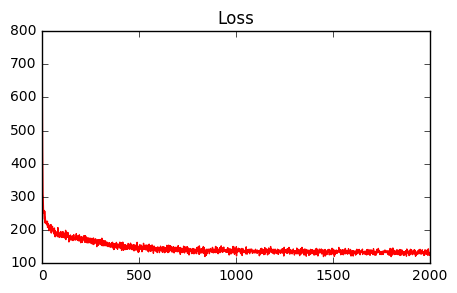

Average loss at the 2000 th iteration: 133.39588748


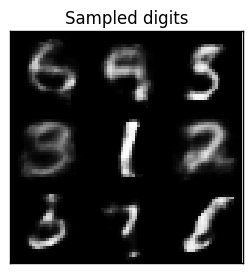

In [13]:
Z_dim = 100 
run(2000, plot_update=200)

### 2.3 Visualize latent space (15)
Implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space. 

Compare your result to Kingma 2014, Appendix A. What are the differences and why?

In [14]:
Z_dim = 2
lr = 1e-2

# encoder network initialization (weights and biases)
Wxh2 = init_weight(size=[X_dim, h_dim])
bxh2 = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu2 = init_weight(size=[h_dim, Z_dim])
bhz_mu2 = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var2 = init_weight(size=[h_dim, Z_dim])
bhz_var2 = Variable(torch.zeros(Z_dim), requires_grad=True)

# decoder network initialization (weights and biases)
Wzh2 = init_weight(size=[Z_dim, h_dim])
bzh2 = Variable(torch.zeros(h_dim), requires_grad=True)
Whx2 = init_weight(size=[h_dim, X_dim])
bhx2 = Variable(torch.zeros(X_dim), requires_grad=True)

# final model composed of the created matrices and biases, along with an Adam optimizer that
# performs stochastic gradient descent along with learning rate tuningparams2 = [Wxh2, bxh2, Whz_mu2, bhz_mu2, Whz_var2, bhz_var2, Wzh2, bzh2, Whx2, bhx2]
solver2 = torch.optim.Adam(params2, lr=lr)

# encoding step (X -> z)
def Q2(X):
    h = nn.relu(X.mm(Wxh2) + bxh2.repeat(X.size(0), 1))
    z_mu = h.mm(Whz_mu2) + bhz_mu2.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var2) + bhz_var2.repeat(h.size(0), 1)
    return z_mu, z_var

# decoding step (z -> X_sample)
def P2(z):
    h = nn.relu(z.mm(Wzh2) + bzh2.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx2) + bhx2.repeat(h.size(0), 1))
    return X

def run2(num_iter, plot_update = 200):
    losses2 = []
        
    for i in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        # extraction of mean and variance of the batch X using the encoder
        z_mu, z_var = Q2(X)
        
        # latent space sampling and generation of a batch sample
        z = sample_z(z_mu, z_var)
        X_sample = P2(z)

        # reconstruction loss, calculated as the binary crossentropy between the batch and reconstructed batch
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size      
        # kl divergence loss
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        
        loss = recon_loss + kl_loss
        losses2.append(loss.data[0])
        
        # gradients calculation
        loss.backward()
        
        # optimization step
        solver2.step()
        for p in params2:
            p.grad.data.zero_()
         
        # loss and samples plot
        if i % plot_update == plot_update - 1:
            plot_loss_digits(losses2, P2, i)
        plt.close()

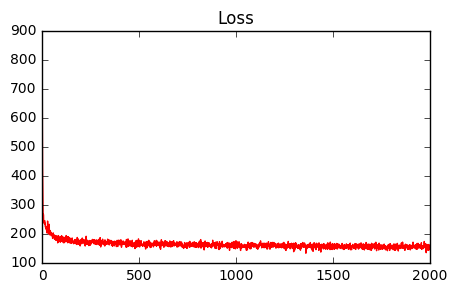

Average loss at the 2000 th iteration: 157.484327077


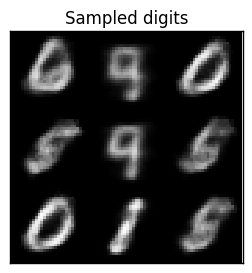

In [15]:
Z_dim = 2
run2(2000, plot_update=200)

## Manifold generation

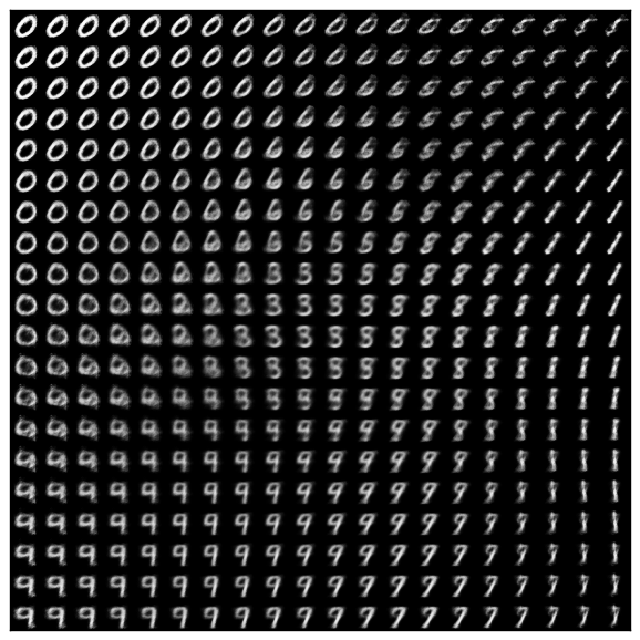

In [16]:
# creation of a sampling vector
grid_size = 20
lim = 2
temp = [[0, 0]] * grid_size * grid_size
for i in range(grid_size):
    for j in range(grid_size):
        temp[i*grid_size + j] = [-lim + (2* lim /(grid_size-1.0)) * i, -lim + (2* lim /(grid_size-1.0)) * j]

# digits generation
r = Variable(torch.FloatTensor(temp))
X_sample = P2(r)
temp = X_sample.data.numpy()

plt.figure(figsize=(8, 8))

# digits stitching (only one print instead of grid_size*grid_size prints)
image = np.zeros((28*grid_size, 28*grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        image[28*i:28*(i+1), 28*j:28*(j+1)] = temp[i*grid_size+j].reshape((28, 28))

plt.imshow(image, interpolation='none', cmap='gray')
plt.xticks([])
plt.yticks([])  

plt.show()

The plotted manifold is composed by a grid sampling with bounds [-2, 2], in order to capture most of the variance of the latent space encoding. It can be seen that the same digits appear in specific regions, and that the digit "4" is the one that the autoencoder has more trouble generating. Compared to the manifold generated by Kingma (2014), it can be seen that the results are quite similar, although less defined. Another difference to notice is that the reference manifold appears to have more robust spatial subdivision of the various classes than the generated one, and this phenomenon could be explained by the fact that our trained autoencoder is not as tuned as the referenced one. We believe that longer training, hyper-parameters tuning and more optimizations (normalization and smart initalization) could lead to better results although the presented ones are already quite good.